In [1]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from METRICS import *
import import_ipynb

### Leer dataset

In [2]:
PATHDATA_MFFC_AVG = '../../data/audios_MFCC_average.csv'
df = pd.read_csv(PATHDATA_MFFC_AVG, header = None)
data = df.values #Convertimos en un  numpy array

In [3]:
X = data[:,0:-3]
Y = data[:,-2]
print('Tamaño dataSet', X.shape)
print('\n')
Y=  np.reshape(Y,(np.size(Y,0),1))
groups = data[:,-1]
tracks = data[:,-3:-2]

Tamaño dataSet (1500, 20)




### Número de clases

In [4]:
n_classes=len(np.unique(Y))
print('Número de clases:', n_classes)

Número de clases: 5


### Número de hablantes

In [5]:
n_groups = len(np.unique(groups))
print('Número de hablantes diferentes', n_groups)

Número de hablantes diferentes 23


### Número de Audios

In [6]:
n_tracks = len(np.unique(tracks))
print('Número de audios diferentes',n_tracks)

Número de audios diferentes 150


## Dividir el dataset (train/test) 0.8/0.2

In [7]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
gss.get_n_splits()
for train_index, test_index in gss.split(X, Y, groups=groups):
    X_train_original, X_test__original = X[train_index], X[test_index]
    #print(X_train, X_test)
    Y_train__original, Y_test__original = Y[train_index], Y[test_index]
    #print(y_train, y_test)
    groups_original = groups[train_index]
    groups_test_original=groups[test_index]
    tracks_train_original = tracks[train_index]
    tracks_test_original = tracks[test_index]   

### Número de clases en test

In [8]:
n_classes_test=len(np.unique(Y_test__original))
print('Número de clases:', n_classes_test)

Número de clases: 5


In [9]:
#groups_original = groups_original.reshape(groups_original.shape[0],1)
groups_original.shape

(1370,)

In [10]:
X_train_original.shape

(1370, 20)

In [11]:
Y_train__original.shape

(1370, 1)

In [12]:
tracks_train_original.shape

(1370, 1)

# GaussianMixture (GMM) 

In [13]:
FOLDS = 10
TRAIN_SIZE = 0.8

## 1. Mejor modelo

Usamos X_train_original y Y_train__original para seleccionar la mejor combinación de parametros y posteriormente validar dichos res]ultados con el conjunto X_test__original y Y_test__original.

<b>Nota:</b> el conjunto X_train_original se divide en dos conjuntos train y dev a una proporción de 80 a 20.


In [14]:
parameters ={'n_components' : [2,3,4,5,6,7,8,9,10],'covariance_type': ['tied','full','spherical','diag']}
GMM =GaussianMixture()#Configurar el modelo
model_trained_gmm = METRICS.build_model(self=1, model=GMM, parameters=parameters,folds=FOLDS,train_size=TRAIN_SIZE, X=X_train_original,Y=Y_train__original,groups_original=groups_original)
best_params_gmm = model_trained_gmm.cv_results_['params'][model_trained_gmm.best_index_]
print(best_params_gmm)

{'covariance_type': 'diag', 'n_components': 5}


In [15]:
params_acurracy = ['mean_train_Accuracy','mean_test_Accuracy','std_train_Accuracy','std_test_Accuracy']
best_acurracy_gmm = []
for p in params_acurracy:
    parameter_acurracy =model_trained_gmm.cv_results_[p][model_trained_gmm.best_index_]
    best_acurracy_gmm.append({p:parameter_acurracy})
print("Resultados mejor modelo: ", best_params_gmm)
best_acurracy_gmm

Resultados mejor modelo:  {'covariance_type': 'diag', 'n_components': 5}


[{'mean_train_Accuracy': 0.21179575686440982},
 {'mean_test_Accuracy': 0.21592765567765565},
 {'std_train_Accuracy': 0.02882942406726986},
 {'std_test_Accuracy': 0.04059962286242447}]

## 2. Evalución mejor modelo con el conjunto de test

<b>Nota:</b> Usamos los conjuntos X_test__original y Y_test__original para evaluar el comportamiento del mejor modelo con datos

verdaderos [4.0, 4.0, 4.0, 4.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 0.0, 1.0, 1.0]
predi [4.0, 1.0, 1.0, 4.0, 4.0, 1.0, 4.0, 4.0, 3.0, 4.0, 4.0, 1.0, 1.0]
Accuracy:  0.38461538461538464 


classification report :
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.40      1.00      0.57         2
         2.0       0.00      0.00      0.00         4
         3.0       1.00      0.50      0.67         2
         4.0       0.29      0.50      0.36         4

    accuracy                           0.38        13
   macro avg       0.34      0.40      0.32        13
weighted avg       0.30      0.38      0.30        13



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


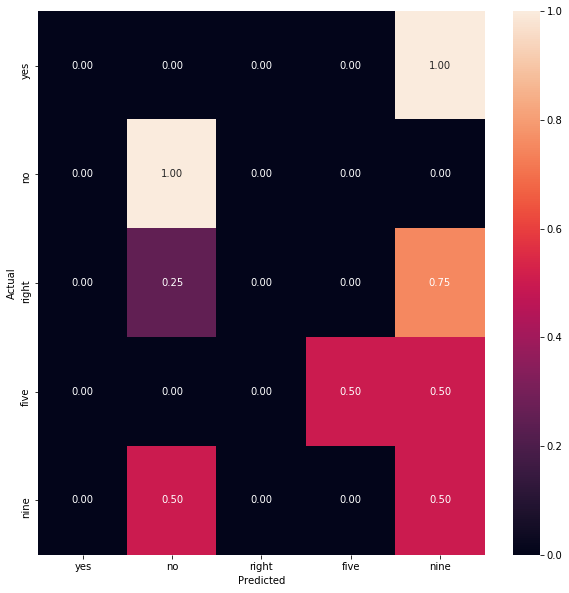

In [16]:
clases = np.array(['yes','no','right','five','nine'])

#clases = len(np.unique(Y_test__original))

gmm_best_estimator = model_trained_gmm.best_estimator_
metrics = METRICS.Metrics(self=1,model=gmm_best_estimator,X_test=X_test__original,Y_test=Y_test__original,tracks_test=tracks_test_original,clases=clases)

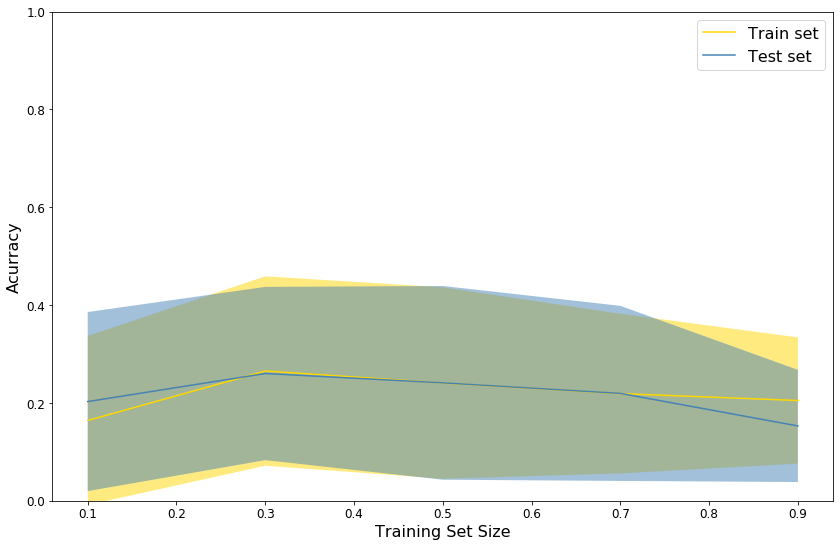

In [17]:
best_params_GMM = {'covariance_type': [str(best_params_gmm['covariance_type'])], 'n_components': [int(best_params_gmm['n_components'])]}
df_split_params =METRICS.learning_curve(self=METRICS,model=GMM,best_parameters=best_params_GMM,folds=10, X=X,Y=Y,groups=groups)

# Random Forest Classifier 

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
parameters = [{'max_depth': [10,20,30],'n_estimators': [400, 600, 800, 1000, 1800, 2000]}]
RandomTreeModel = RandomForestClassifier()#Configurar el modelo
model_trained_Tree = METRICS.build_model(self=1, model=RandomTreeModel, parameters=parameters,folds=FOLDS,train_size=TRAIN_SIZE, X=X_train_original,Y=Y_train__original,groups_original=groups_original)
best_params_Tree = model_trained_Tree.cv_results_['params'][model_trained_Tree.best_index_]
print(best_params_gmm)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'covariance_type': 'diag', 'n_components': 5}


In [20]:
params_acurracy = ['mean_train_Accuracy','mean_test_Accuracy','std_train_Accuracy','std_test_Accuracy']
best_acurracy_Tree= []
for p in params_acurracy:
    parameter_acurracy =model_trained_Tree.cv_results_[p][model_trained_Tree.best_index_]
    best_acurracy_Tree.append({p:parameter_acurracy})
print("Resultados mejor modelo: ", best_params_Tree)
best_acurracy_Tree

Resultados mejor modelo:  {'max_depth': 20, 'n_estimators': 1800}


[{'mean_train_Accuracy': 1.0},
 {'mean_test_Accuracy': 0.3674861984420808},
 {'std_train_Accuracy': 0.0},
 {'std_test_Accuracy': 0.023374181689884574}]

verdaderos [4.0, 4.0, 4.0, 4.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 0.0, 1.0, 1.0]
predi [1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 1.0]
Accuracy:  0.07692307692307693 


classification report :
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.17      0.50      0.25         2
         2.0       0.00      0.00      0.00         4
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         4

    accuracy                           0.08        13
   macro avg       0.03      0.10      0.05        13
weighted avg       0.03      0.08      0.04        13



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


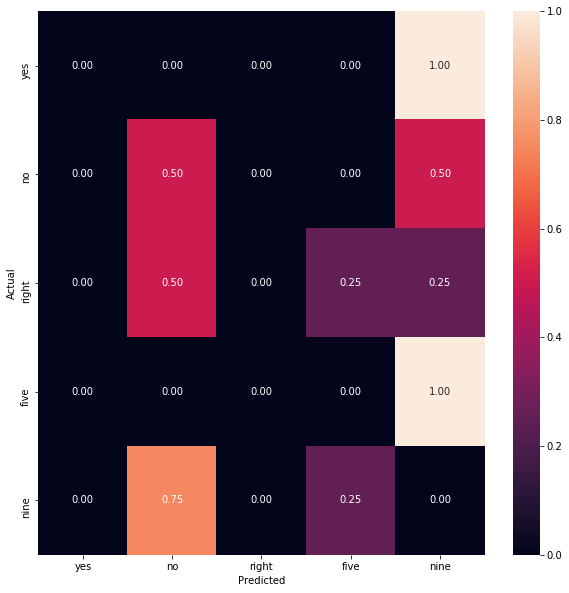

In [21]:
clases = np.array(['yes','no','right','five','nine'])

Tree_best_estimator = model_trained_Tree.best_estimator_
metrics = METRICS.Metrics(self=1,model=Tree_best_estimator,X_test=X_test__original,Y_test=Y_test__original,tracks_test=tracks_test_original,clases=clases)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expect

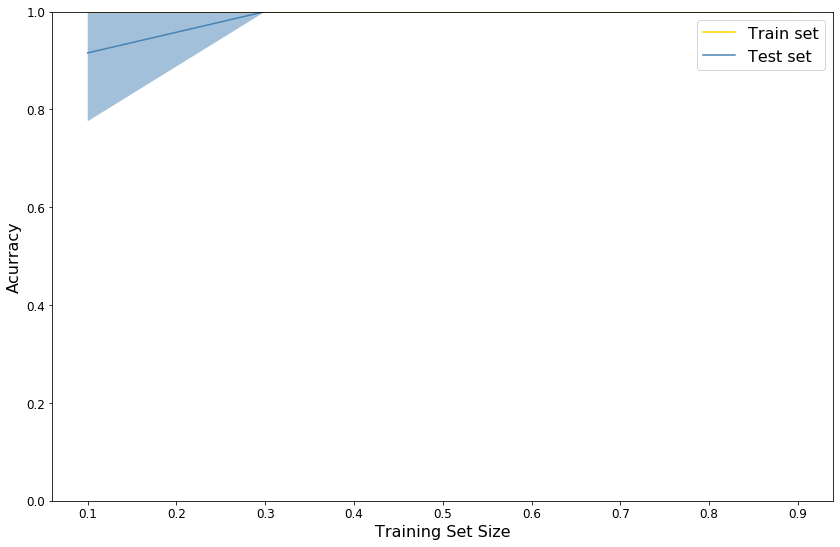

In [22]:
best_params_Tree = {'max_depth': [int(best_params_Tree['max_depth'])], 'n_estimators': [int(best_params_Tree['n_estimators'])]}
RandomTreeModel = RandomForestClassifier()#Configurar el modelo

df_split_params = METRICS.learning_curve(self=METRICS,model=RandomTreeModel,best_parameters=best_params_Tree,folds=10, X=X,Y=Y,groups=groups)

# SVM

In [ ]:
from sklearn.svm import  SVC
parameters = [{'kernel': ['rbf'], 'gamma': [1e-1,1e-10,1e-5],'C': [1,2,3]},
              {'kernel': ['linear'], 'C': [1,2,3]},
              {'kernel':['poly'],'C': [1,2,3],'degree':[1,2,3]}
             ]
SVMC = SVC()#Configurar el modelo
model_trained_SVMC = METRICS.build_model(self=1, model=SVMC, parameters=parameters,folds=FOLDS,train_size=TRAIN_SIZE, X=X_train_original,Y=Y_train__original,groups_original=groups_original)
best_params_SVMC = model_trained_SVMC.cv_results_['params'][model_trained_SVMC.best_index_]
print(best_params_SVMC)

In [ ]:
params_acurracy = ['mean_train_Accuracy','mean_test_Accuracy','std_train_Accuracy','std_test_Accuracy']
best_acurracy_SVMC= []
for p in params_acurracy:
    parameter_acurracy =model_trained_SVMC.cv_results_[p][model_trained_SVMC.best_index_]
    best_acurracy_SVMC.append({p:parameter_acurracy})
print("Resultados mejor modelo: ", best_params_SVMC)
best_acurracy_SVMC

In [ ]:
SVMC_best_estimator = model_trained_SVMC.best_estimator_
metrics = METRICS.Metrics(self=1,model=SVMC_best_estimator,X_test=X_test__original,Y_test=Y_test__original,tracks_test=tracks_test_original,clases=clases)

In [ ]:
best_params_SVMC = {'C': [int(best_params_SVMC['C'])], 'degree': [int(best_params_SVMC['degree'])], 'kernel': [int(best_params_SVMC['kernel'])]}

df_split_params = METRICS.learning_curve(self=METRICS,model=SVMC,best_parameters=best_params_SVMC,folds=10, X=X,Y=Y,groups=groups)

# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
parameters = [{'hidden_layer_sizes': [(32,32),(36,36),(40,40)]},
{'hidden_layer_sizes': [(32,32,32),(36,36,36),(40,40,40)]},
{'hidden_layer_sizes': [(32,32,32,32),(36,36,36,36),(40,40,40,40)]}]
mlp = MLPClassifier()#Configurar el modelo
model_trained_MLP = METRICS.build_model(self=1, model=mlp, parameters=parameters,folds=FOLDS,train_size=TRAIN_SIZE, X=X_train_original,Y=Y_train__original,groups_original=groups_original)
best_params_MLP = model_trained_MLP.cv_results_['params'][model_trained_MLP.best_index_]
print(best_params_MLP)

In [ ]:
params_acurracy = ['mean_train_Accuracy','mean_test_Accuracy','std_train_Accuracy','std_test_Accuracy']
best_acurracy_MLP= []
for p in params_acurracy:
    parameter_acurracy =model_trained_MLP.cv_results_[p][model_trained_MLP.best_index_]
    best_acurracy_MLP.append({p:parameter_acurracy})
print("Resultados mejor modelo: ", best_params_MLP)
best_acurracy_MLP

In [ ]:
MLP_best_estimator = model_trained_MLP.best_estimator_
metrics = Metrics(MLP_best_estimator,X_test__original,Y_test__original)
metrics = METRICS.Metrics(self=1,model=MLP_best_estimator,X_test=X_test__original,Y_test=Y_test__original,tracks_test=tracks_test_original,clases=clases)

In [ ]:
best_params_MLP = {'hidden_layer_sizes' : [int(best_params_MLP['hidden_layer_sizes'])]}
df_split_params =learning_curve(model=MLP_best_estimator,best_parameters=best_params_MLP,folds=10, X=X,Y=Y,groups=groups)